# Modelling Solar generation across Multiple Sites

This example shows how `timeserio` helps building deep learning models for time series forecasting. Especially,
we deal with the case of many related timeseries.

We demonstrate some core functionality and concepts, without striving for model accuracy or seeking out additional features like historic weather forecasts.

We will be using the dataset on solar (photo-voltaic, PV) generation potential across Europe, as collected by [SETIS](https://setis.ec.europa.eu/EMHIRES-datasets). The dataset presents solar generation, normalized to the solar capacity installed as of 2015.

## Download the data

In [1]:
!mkdir -p ~/tmp/datasets; cd ~/tmp/datasets; wget https://setis.ec.europa.eu/sites/default/files/EMHIRES_DATA/Solar/EMHIRESPV_country_level.zip; unzip -o EMHIRESPV_country_level.zip; rm EMHIRESPV_country_level.zip

--2020-03-23 00:32:13--  https://setis.ec.europa.eu/sites/default/files/EMHIRES_DATA/Solar/EMHIRESPV_country_level.zip
Resolving setis.ec.europa.eu (setis.ec.europa.eu)... 139.191.207.52
Connecting to setis.ec.europa.eu (setis.ec.europa.eu)|139.191.207.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93401258 (89M) [application/zip]
Saving to: ‘EMHIRESPV_country_level.zip’

EMHIRESPV_country_l 100%[===================>]  89.07M  6.04MB/s    in 17s     

2020-03-23 00:32:32 (5.31 MB/s) - ‘EMHIRESPV_country_level.zip’ saved [93401258/93401258]

Archive:  EMHIRESPV_country_level.zip
  inflating: EMHIRESPV_TSh_CF_Country_19862015.xlsx  


## Download data and save in a more performant format

In [0]:
import pandas as pd
import numpy as np

In [3]:
%%time
df = pd.read_excel("~/tmp/datasets/EMHIRESPV_TSh_CF_Country_19862015.xlsx")

CPU times: user 1min 24s, sys: 662 ms, total: 1min 24s
Wall time: 1min 24s


In [4]:
df.head(3)

,Time_step,Date,Year,Month,Day,Hour,AL,AT,BA,BE,BG,CH,CY,CZ,DE,DK,EE,ES,FI,FR,EL,HR,HU,IE,IT,LT,LU,LV,ME,MK,NL,NO,PL,PT,RO,RS,SI,SK,SE,XK,UK
0,1,1986-01-01 00:00:00,1986,1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1986-01-01 01:00:00,1986,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1986-01-01 02:00:00,1986,1,1,2,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Reshape data to tall format
We add a `country` column to identify each table row.

In [0]:
id_vars = ['Time_step', 'Date', 'Year', 'Month', 'Day', 'Hour']
country_vars = list(set(df.columns) - set(id_vars))
df_tall = pd.melt(df, id_vars=id_vars, value_vars=country_vars, var_name="country", value_name="generation")

In [6]:
df_tall.head(10)

,Time_step,Date,Year,Month,Day,Hour,country,generation
0,1,1986-01-01 00:00:00,1986,1,1,0,RO,0.000000
1,2,1986-01-01 01:00:00,1986,1,1,1,RO,0.000000
2,3,1986-01-01 02:00:00,1986,1,1,2,RO,0.000000
3,4,1986-01-01 03:00:00,1986,1,1,3,RO,0.000000
4,5,1986-01-01 04:00:00,1986,1,1,4,RO,0.000000
5,6,1986-01-01 05:00:00,1986,1,1,5,RO,0.000000
6,7,1986-01-01 06:00:00,1986,1,1,6,RO,0.000000
7,8,1986-01-01 07:00:00,1986,1,1,7,RO,0.059359
8,9,1986-01-01 08:00:00,1986,1,1,8,RO,0.098980
9,10,1986-01-01 09:00:00,1986,1,1,9,RO,0.111118


## Data Exploratory

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
%%time
df = df_tall

CPU times: user 29 µs, sys: 0 ns, total: 29 µs
Wall time: 33.6 µs


In [9]:
print(' '.join(sorted(df['country'].unique())))

AL AT BA BE BG CH CY CZ DE DK EE EL ES FI FR HR HU IE IT LT LU LV ME MK NL NO PL PT RO RS SE SI SK UK XK


In [0]:
plot_countries = ['ES', 'UK', 'FI', ]

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


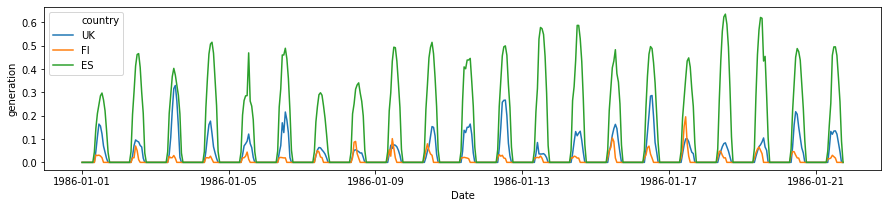

In [11]:
plt.figure(figsize=(15, 3))
sns.lineplot(
    data=df[(df['Time_step'] < 500) & (df['country'].isin(plot_countries))],
    x='Date', y='generation', hue='country',
)

In [0]:
df_monthly = df.groupby(['Month', 'country']).mean().reset_index()

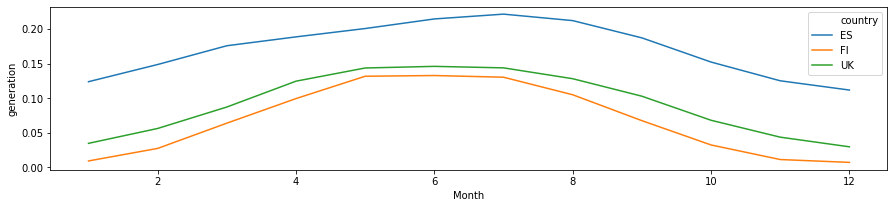

In [13]:
plt.figure(figsize=(15, 3))
sns.lineplot(
    data=df_monthly[df_monthly['country'].isin(plot_countries)],
    x='Month', y='generation', hue='country',
)

In [0]:
df_daily = df.groupby(['Hour', 'country']).mean().reset_index()

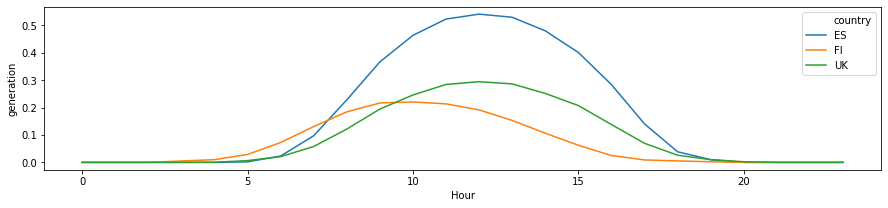

In [15]:
plt.figure(figsize=(15, 3))
sns.lineplot(
    data=df_daily[df_daily['country'].isin(plot_countries)],
    x='Hour', y='generation', hue='country',
)

In [0]:
df_yearly = df.groupby(['Year', 'country']).mean().reset_index()

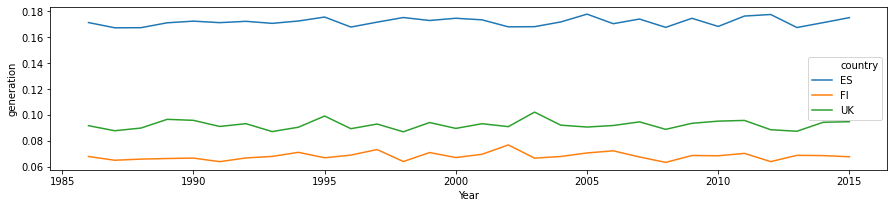

In [17]:
plt.figure(figsize=(15, 3))
sns.lineplot(
    data=df_yearly[df_yearly['country'].isin(plot_countries)],
    x='Year', y='generation', hue='country',
)

### Preliminary observations

The timeseries for different countries exhibit a lot of similarity - they will have similar daily and seaonal shapes. At the same time, the curves have different scaling (due to latitudes and weather), and different time offsets (due to longitude). We can build models to incorporate these as external features, or learn the relevant features from the available data only!

### Store to parquet
[Apache Parquet](https://parquet.apache.org/documentation/latest/) is a much preferred data format for columnar numerical data - it is much faster to read (see below), is fully compatible with tools like `pandas` and Spark, and allows easy partitioning of large datasets.

In [18]:
%%time
df_tall.to_parquet("/content/tall.parquet")

CPU times: user 1.88 s, sys: 237 ms, total: 2.11 s
Wall time: 2.08 s


In [19]:
!ls /content -l

total 126464
drwxr-xr-x 1 root root      4096 Mar 18 16:23 sample_data
-rw-r--r-- 1 root root 129492873 Mar 23 00:34 tall.parquet


In [0]:
from google.colab import files
files.download("/content/tall.parquet")

### Store to partitioned parquet (For Distributed Environment)


```python
%%time
df_tall.to_parquet("~/tmp/datasets/EMHIRESPV_TSh_CF_Country_19862015_partitioned/", partition_cols=["country"])

!tree -h --filelimit=10 ~/tmp/datasets
```